In [1]:
import pypsa
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import cartopy.crs as ccrs

In [2]:
csv_folder_name = "Nepal_Data"

fig_size = (12,6)

network = pypsa.Network()
network.import_from_csv_folder(csv_folder_name)

INFO:pypsa.io:Imported network Nepal_Data has buses, generators, lines, loads, transformers


In [3]:
network.pf()

INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots Index(['now'], dtype='object', name='snapshot')
INFO:pypsa.pf:Newton-Raphson solved in 5 iterations with error of 0.000000 in 0.095963 seconds


{'n_iter': SubNetwork  0
 snapshot     
 now         5,
 'error': SubNetwork             0
 snapshot                
 now         6.711787e-10,
 'converged': SubNetwork     0
 snapshot        
 now         True}

<Axes: xlabel='snapshot'>

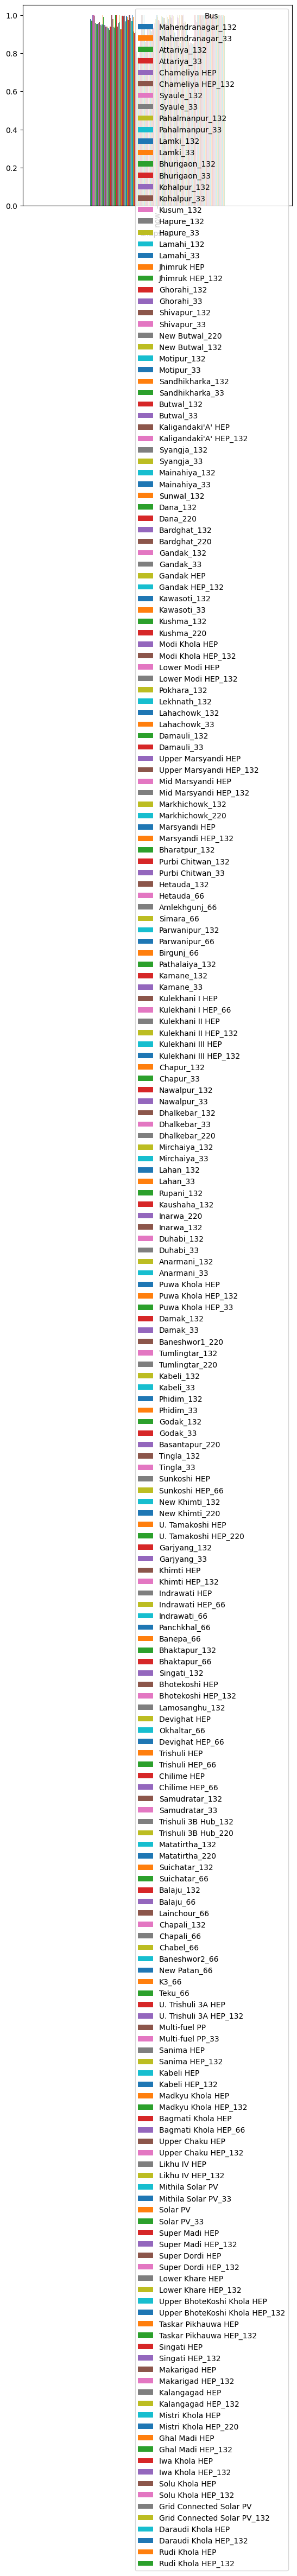

In [8]:
network.buses_t.v_mag_pu.plot.bar()